In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *

import meteo
import metpy.calc as mpcalc
from metpy.units import units
import lcl


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d, perc_distribution_pvalue
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy')

SAVE QVAPOR

In [5]:
# load data
QVAPOR_day = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
QVAPOR_day = QVAPOR_day['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000')).groupby('time_counter.day').mean()

In [6]:
# select data oversea
QVAPOR_day = QVAPOR_day.where(sea_mask, drop=False)

In [7]:
# def lon lat time
lon_M = QVAPOR_day['nav_lon_grid_M'].values
lat_M = QVAPOR_day['nav_lat_grid_M'].values
#lon, lat = np.meshgrid(lon_M, lat_M)

# time = QVAPOR_day['time_counter'].values.astype('<M8[s]')
# time_day = QVAPOR_day['day'].astype('<M8[s]')

KeyError: 'time_counter'

GEOPOTENTIAL AND PRESSURE

In [7]:
pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

#pres_base = pres_base.where(sea_mask, drop=False)


In [8]:
pres = (pres+pres_base)/100.                # hectoPascals
pres = pres.where(sea_mask, drop=False)

del pres_base

In [9]:
# mean base pressure over domain
mean_vert_pres = np.nanmean(pres, axis=(0,2,3))

In [8]:
### LOAD PRESSURE COLUMN
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

In [9]:
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH['PH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))/9.81


In [ ]:
GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask, drop=False)

del GPH_base

In [ ]:
i = np.arange(0,38)
GPH = 0.5*(GPH[:,i,:,:]+GPH[:,i+1,:,:])

# mean GPH over domain
GPH_mean = GPH.mean(axis=(0,2,3))

In [ ]:
# compute daily means
'''pres_day = pres.groupby('time_counter.day').mean()
GPH_day = GPH.groupby('time_counter.day').mean()'''

OPENING HOURLY DATASETS

In [9]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))


In [10]:
# daily varaibles
# select sst, q2, U, PBLH

sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask, drop=False).values;                              

PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask, drop=False).values;             


In [11]:
# consider only .values in previous data
QVAPOR_day = QVAPOR_day.values
# pres = pres.values
# GPH = GPH.values

In [12]:
# compute anomalies daily data
s = 100

# dsst_day = np.zeros(sst_day.shape)
dQVAPOR_day = np.zeros(QVAPOR_day.shape)
# dPBLH_day = np.zeros(PBLH_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
#     sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
#     dsst_day[t] = sst_day[t] - sst_ave
    
#     PBLH_ave = gm.nan_gaussian_filter(PBLH_day[t],s)
#     dPBLH_day[t] = PBLH_day[t] - PBLH_ave
    
    for h in range(0,QVAPOR_day.shape[1]):
        q_ave = gm.nan_gaussian_filter(QVAPOR_day[t,h],s)                            
        dQVAPOR_day[t,h] = QVAPOR_day[t,h] - q_ave

0
10
20


In [20]:
#  SAVE ANOMALIES DATA

my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dQVAPOR_day_feb.npy', [dQVAPOR_day])
# my_save_data('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_day_feb.npy', [dsst_day])
# my_save_data('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', [dPBLH_day])

file already exists - DELETING IT and creating it anew


In [10]:
dQVAPOR_day = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dQVAPOR_day_feb.npy')

In [12]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [22]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    f.close()

In [30]:
# PERC DISTRIBUTION dQVAPOR vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

# percentiles
# x,y,perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top, perc_fixbin
# dist_x, dist_y, std_y, stderr_y, npoints_y, pvalue_y, pvalue_y_sub

pdist_dsst_day, pdist_dQVAPOR_day, pstd_dQVAPOR_day, pstderr_dQVAPOR_day, pnpoints_dQVAPOR, ppvalue_dQVAPOR_day_sub = \
dist_3d_subsample(dsst_day, dQVAPOR_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [21]:
p_dsst_dqva = [pdist_dsst_day, pdist_dQVAPOR_day, pstd_dQVAPOR_day, pstderr_dQVAPOR_day, pnpoints_dQVAPOR, ppvalue_dQVAPOR_day_sub]
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/pdistrs_dSST_dQVAPOR_day_feb.npy', p_dsst_dqva)

In [22]:
# fixed bins dQVAPOR vs dSST
# dist_dsst_day, dist_dQVAPOR_day, std_dQVAPOR_day, stderr_dQVAPOR_day, npoints_dQVAPOR, pvalue_dQVAPOR_day_sub = \
# dist_3d_subsample(dsst_day, dQVAPOR_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='fb')


0
10
20
30


In [22]:
# PBLH IN PRESSURE VALUES! 
# output is in hPa
PBLH_pres = mpcalc.height_to_pressure_std(PBLH_day*units.meters)
PBLH_pres = PBLH_pres.magnitude #.m_as('hPa')

In [29]:
# DISTRIBUTION PBLH vs dSST bin - DAILY 
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

#  PBLH distrib

# perc
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstderr_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')



"# bins\ndist_dsst, dist_PBLH_dsst, std_PBLH_dsst, stderr_PBLH_dsst, npoints_PBLH_dsst, pvalue_PBLH_dsst = distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'fb')"

In [23]:
## LOAD PBLH vs dSST data!
with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_dSST_day_feb.npy', 'rb') as f:
    pdist_dsst = np.load(f)
    pdist_PBLH_dsst = np.load(f)
    f.close()

/venus/tesi_ale/img_EU/QVAPOR/daily/FEB/pdist_dsst_dqvapor_lowtropo_2%.png


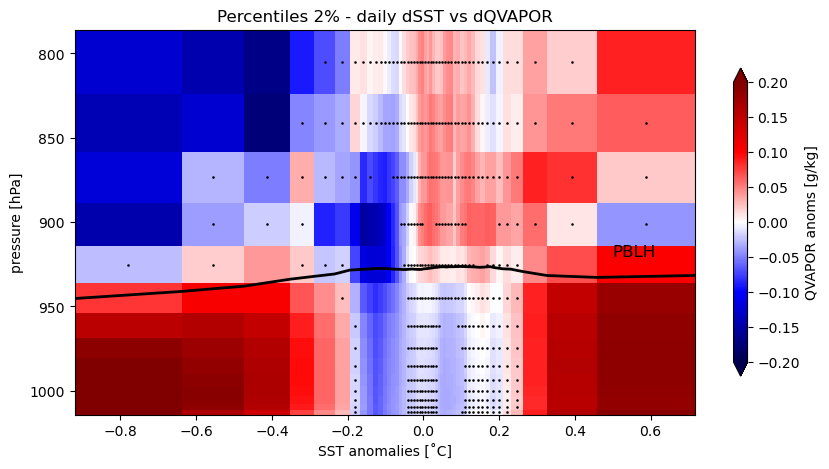

In [34]:
p_level_plot = int(15)

perc = True
title = 'Percentiles' if perc else 'Fixed bins'
x = pdist_dsst_day if perc else dist_dsst_day
var = pdist_dQVAPOR_day if perc else dist_dQVAPOR_day
minval = -0.2 ; maxval = -minval

fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot]*1000, vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} 2% - daily dSST vs dQVAPOR')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('QVAPOR anoms [g/kg]')

var_pbl = pdist_PBLH_dsst if perc else dist_PBLH_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.5, 920, 'PBLH', fontsize=12, color='k')




# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dQVAPOR_day_sub[0:p_level_plot] if perc else pvalue_dQVAPOR_day_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')




# savefig
path_img = '/venus/tesi_ale/img_EU/QVAPOR/daily/FEB/' if perc else '/venus/tesi_ale/img_EU/QVAPOR/daily/bins/FEB/'
filename = path_img + 'pdist_dsst_dqvapor_lowtropo_2%.png' if perc else path_img + 'bins_dsst_dqvapor_lowtropo_hatch.png'
# plt.savefig(filename)
print(filename)
del filename

In [104]:
#######   THIS IS TO FIND THE VALUES OF dQVAPOR AT THE LEVEL CLOSEST TO PBLH    #######


where = np.zeros_like(pdist_PBLH_dsst)

for i in range(0, len(pdist_PBLH_dsst)):
    dist = np.abs(mean_vert_pres - pdist_PBLH_dsst[i])
    min_dist = np.min(dist)
    where[i] = np.argwhere(dist==min_dist).astype(int)

qvapor_at_pblh = np.zeros_like(pdist_dsst_day)
for i in range(0, len(pdist_dsst_day)):
    qvapor_at_pblh[i] = pdist_dQVAPOR_day[int(where[i]), i]



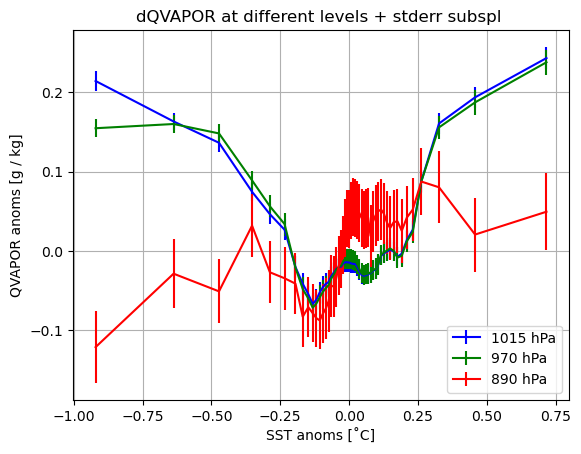

In [39]:
###  QVAPOR SCATTER AT DIFFERENT ALTITUDES  
plt.errorbar(pdist_dsst_day, pdist_dQVAPOR_day[0,:]*1000, yerr=pstderr_dQVAPOR_day[0,:]*1000, xerr=None,\
             label='1015 hPa', ecolor='b', linestyle='-', color='b')

plt.errorbar(pdist_dsst_day, pdist_dQVAPOR_day[7,:]*1000, yerr=pstderr_dQVAPOR_day[7,:]*1000, xerr=None,\
             label='970 hPa', ecolor='g', linestyle='-', color='g')

plt.errorbar(pdist_dsst_day, pdist_dQVAPOR_day[11,:]*1000, yerr=pstderr_dQVAPOR_day[11,:]*1000, xerr=None,\
             label='890 hPa', ecolor='r', linestyle='-', color='r')

# plt.errorbar(pdist_dsst_day, pdist_dQVAPOR_day[13,:]*1000, yerr=pstderr_dQVAPOR_day[13,:]*1000, xerr=None,\
#              label='825 hPa', ecolor='k', linestyle='-', color='k')

# plt.plot(pdist_dsst_day, qvapor_at_pblh*1000, '.-k', label='PBLH nrst')

plt.legend()

plt.ylabel('QVAPOR anoms [g / kg]')
plt.xlabel('SST anoms [˚C]')
plt.title('dQVAPOR at different levels + stderr subspl ')

# plt.savefig('/venus/tesi_ale/img_EU/QVAPOR/daily/FEB/dQVAPOR_levels_2%.png')

plt.grid()

In [ ]:
# HOURLY tutto da rifare!!!!

In [ ]:
# HOURLY 

In [ ]:
# read QVAPOR anomalies
path_dir = '/media/fabien/DAGOBAH1/WRF_EUREC4A/CNT/FEB/01_var_33levels/anomalies/'
qv_files = path_dir + 'QVAPOR_anomalies_150km_d02_2020-02-'
qv_list = sorted(glob.glob(qv_files + '*'))
ds_tmp = xr.open_mfdataset(qv_list, concat_dim='XTIME', combine='nested')

In [ ]:
maskl_lon = (ds_tmp.XLONG >= minlon) & (ds_tmp.XLONG <= maxlon)
maskl_lat = (ds_tmp.XLAT >= minlat) & (ds_tmp.XLAT <= maxlat)
ds_q = ds_tmp.where(maskl_lon & maskl_lat, drop=True)

In [ ]:
dQVAPOR = ds_q['QVAPOR'].values*seamask

In [ ]:
# DISTRIBUTION dQVAPOR vs dSST bin - HOURLY
str_control = 'SST'; str_variable = "QVAPOR"
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
theshold_n = 100
dist_dqvapor_dsst = np.zeros((dQVAPOR.shape[1],nbins))
npoint_dqvapor_dsst = np.zeros((dQVAPOR.shape[1],nbins))
x = dsst.copy()
control = dsst.reshape(-1)
for h in range(0,dQVAPOR.shape[1]):
    y = dQVAPOR[:,h,:,:].copy()
    variable = y.reshape(-1)
    ##### Fixed bin distribution: fb
    dist_dsst, dist_dqvapor_dsst[h], std_err, npoint_dqvapor_dsst[h] = fb_distribution_mod(control, variable, nbins, theshold_n, perc_step)

In [ ]:
# figure dQVAPOR vs dSST bin - HOURLY
fig = plt.figure(figsize=(10, 5))
plt.pcolormesh(dist_dsst, GP[:33], dist_dqvapor_dsst*1000., vmin=-0.6, vmax=0.6, cmap='seismic')
plt.gca().invert_yaxis()
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label('QVAPOR anomalies [g kg-1]')

In [ ]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/'
np.savetxt(path_bindist + 'dist_dsst.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_dQVAPOR_dsst.txt', dist_dqvapor_dsst)
np.savetxt(path_bindist + 'npoint_dQVAPOR_dsst.txt', npoint_dqvapor_dsst)

In [ ]:
# DISTRIBUTION dQVAPOR vs SST bin - HOURLY
str_control = 'SST'; str_variable = "QVAPOR"
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
theshold_n = 100
dist_dqvapor_sst = np.zeros((dQVAPOR.shape[1],nbins))
npoint_dqvapor_sst = np.zeros((dQVAPOR.shape[1],nbins))
x = sst.copy()
control = x.reshape(-1)
for h in range(0,dQVAPOR.shape[1]):
    y = dQVAPOR[:,h,:,:].copy()
    variable = y.reshape(-1)
    ##### Fixed bin distribution: fb
    dist_sst, dist_dqvapor_sst[h], std_err, npoint_dqvapor_sst[h] = fb_distribution_mod(control, variable, nbins, theshold_n, perc_step)

In [ ]:
# figure dQVAPOR vs SST bin - HOURLY
fig = plt.figure(figsize=(10, 5))
plt.pcolormesh(dist_sst-273.15, GP[:33], dist_dqvapor_sst*1000., vmin=-0.6, vmax=0.6, cmap='seismic')
plt.gca().invert_yaxis()
plt.xlabel('SST [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label('QVAPOR anomalies [g kg-1]')

In [ ]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/'
np.savetxt(path_bindist + 'dist_sst.txt', dist_sst)
np.savetxt(path_bindist + 'dist_dQVAPOR_sst.txt', dist_dqvapor_sst)
np.savetxt(path_bindist + 'npoint_dQVAPOR_sst.txt', npoint_dqvapor_sst)

In [ ]:
#   CHECKING THE RH DISTRIBUTIONS, INSTEAD OF ABSOLUTE MOISTURE MAGNITUDES

In [13]:
# retrieve potential temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

# full pot_temp field
# = T+T0 , T0 = 300
pot_temp = pot_temp + 300

In [14]:
# compute actual temperature
# I DID NOT APPLY DAILY MEAN TO PRES!
temperature = pot_temp * ( pres / 1000. )**0.286

In [15]:
temperature = temperature.groupby('time_counter.day').mean()
temperature = temperature.where(sea_mask, drop=False)

In [16]:
#####  NOW APPLY DAILY MEAN TO PRES
pres_day = pres.groupby('time_counter.day').mean()

In [17]:
# compute relative humidity
# RESULT IN %
rh_day = meteo.rhcalc(temperature.values-273.15, pres_day.values, QVAPOR_day)  

In [19]:
my_save_data('/venus/tesi_ale/data_EU/RH/daily/FEB/rh_day.npy', [rh_day])

In [ ]:
## load RH
rh_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh_day.npy')

In [18]:
# compute anomalies
s = 100
drh_day = np.zeros_like(rh_day)

for t in range(0,rh_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,rh_day.shape[1]):
        rh_ave = gm.nan_gaussian_filter(rh_day[t,h],s)                             
        drh_day[t,h] = rh_day[t,h] - rh_ave

0
10
20


In [20]:
my_save_data('/venus/tesi_ale/data_EU/RH/daily/FEB/drh_day.npy', [drh_day])

In [ ]:
## load dRH
drh_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/drh_day.npy')

In [23]:
# correlation quantities

L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# ref mean
popmean = 0.

In [24]:
# COMPUTE PERCENTILE DISTRIBUTIONS
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0.

pdist_dsst, pdist_drh, pstd_drh, pstderr_drh, pnpoints_drh, ppvalue_drh_sub = \
dist_3d_subsample(dsst_day, drh_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [25]:
## load RH
my_save_data('/venus/tesi_ale/data_EU/RH/daily/FEB/pdistrs_dSST_dRH_day_feb.npy', [pdist_dsst, pdist_drh, pstd_drh, pstderr_drh, pnpoints_drh, ppvalue_drh_sub])

In [26]:
## load PBLH distributions
with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_dSST_day_feb.npy', 'rb') as f:
    pdist_dsst = np.load(f)
    pdist_PBLH_dsst = np.load(f)

In [26]:
# compute distributions for PBLH_pres
# otherwise cannot be put in the plots
'''pdist_dsst, pdist_PBLHpr_dsst, pstd_PBLHpr, pstderr_PBLHpr, ppoints_PBLHpr, pvalue_PBLHpr_perc = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin='perc')

dist_dsst, dist_PBLHpr_dsst, std_PBLHpr, stderr_PBLHpr, points_PBLHpr, pvalue_PBLHpr_fb = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin='fb')'''

# distribution_control_fb, distribution_fb, std_err_distribution_fb, number_of_points_fb, p_value

/venus/tesi_ale/img_EU/RH/daily/FEB/pdist_dsst_drh_lowtropo_hatch.png


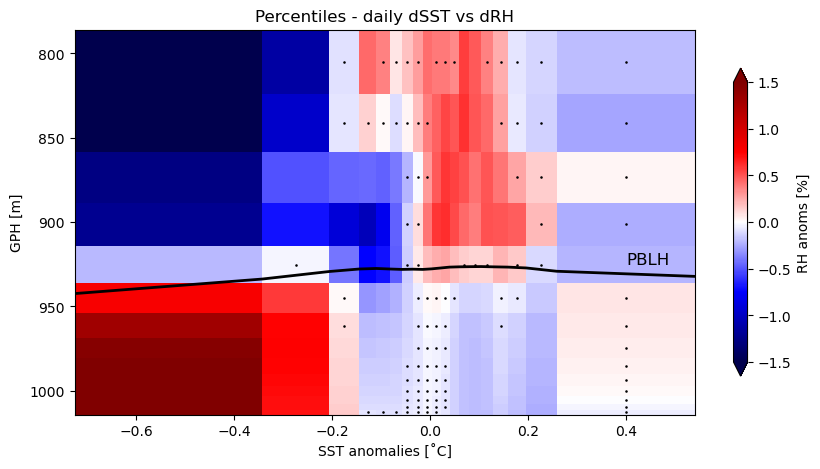

In [48]:
p_level_plot = int(15)

perc = True
title = 'Percentiles' if perc else 'Fixed bins'
x = pdist_dsst if perc else dist_dsst
var = pdist_drh if perc else dist_drh
minval = -1.5 ; maxval = -minval
#levs = np.arange(minval, maxval+0.1, 0.1)


fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot],\
                  vmin=minval, vmax=maxval, cmap='seismic')  #
# p1 = ax1.contourf(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot], \
#                   levels=levs, cmap='seismic')  #vmin=minval, vmax=maxval,
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('GPH [m]')
plt.title(f'{title} - daily dSST vs dRH')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('RH anoms [%]')

var_pbl = pdist_PBLH_dsst if perc else dist_PBLHpr_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.4, 925, 'PBLH', fontsize=12, color='k')



# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_drh_sub[0:p_level_plot] if perc else pvalue_drh_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/RH/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/RH/daily/bins/FEB/'
filename = path_img + 'pdist_dsst_drh_lowtropo_hatch.png' #if perc else path_img + 'bins_dsst_drh_lowtropo_hatch.png'
#plt.savefig(filename)
print(filename)
del filename


In [52]:
mean_vert_pres[8]

954.05237

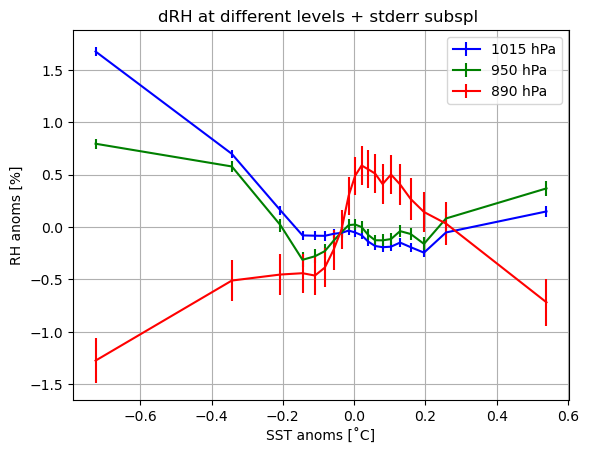

In [54]:
plt.errorbar(pdist_dsst, pdist_drh[0,:], yerr=pstderr_drh[0,:], xerr=None,\
             label='1015 hPa', ecolor='b', linestyle='-', color='b')

plt.errorbar(pdist_dsst, pdist_drh[8,:], yerr=pstderr_drh[8,:], xerr=None,\
             label='950 hPa', ecolor='g', linestyle='-', color='g')

plt.errorbar(pdist_dsst, pdist_drh[11,:], yerr=pstderr_drh[11,:], xerr=None,\
             label='890 hPa', ecolor='r', linestyle='-', color='r')


plt.grid()
plt.legend()

plt.ylabel('RH anoms [%]')
plt.xlabel('SST anoms [˚C]')
plt.title('dRH at different levels + stderr subspl ')

# plt.savefig('/venus/tesi_ale/img_EU/RH/daily/FEB/dRH_levels.png')